# IMMOWEB PROJECT: EXPLORATORY DATA ANALYSIS
Visualization: How many rows and columns?
What is the correlation between the variables and the price? (Why might that be?)
How are variables correlated to each other? (Why?)
Which variables have the greatest influence on the price?
Which variables have the least influence on the price?
How many qualitative and quantitative variables are there? How would you transform these values into numerical values?
Percentage of missing values per column?

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import os
from datetime import datetime

warnings.filterwarnings('ignore')

# better style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# folder fro saving 
output_dir = 'correlation_analysis_plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
session_dir = os.path.join(output_dir, f'analysis_{timestamp}')
os.makedirs(session_dir, exist_ok=True)

print(f"All plots will be saved to: {session_dir}")

# saving plot function
def save_plot(filename, dpi=300):
    filepath = os.path.join(session_dir, filename)
    plt.savefig(filepath, dpi=dpi, bbox_inches='tight', facecolor='white', edgecolor='none')
    print(f"Saved: {filename}")
    return filepath


# Load the dataset
df = pd.read_csv('Cleaned - immoweb-dataset.csv')

# define variable types
binary_vars = ['hasAttic', 'hasBasement', 'hasGarden', 'hasSwimmingPool', 'hasTerrace']
categorical_vars = ['type','subtype', 'region', 'province', 'postCode','buildingCondition', 
                   'floodZoneType', 'heatingType', 'kitchenType', 'epcScore', 'hasLift']
numeric_vars = ['bedroomCount', 'bathroomCount', 'habitableSurface', 'landSurface',
                'parkingCountIndoor', 'parkingCountOutdoor', 'toiletCount', 'price']

#convert bibary vars to categorical
for var in binary_vars:
    df[var]=df[var].astype('category')

#convert postcode to categorical
df["postCode"] = df["postCode"].astype("category")

#convert haslift to categorical if it's boolean
if df['hasLift'].dtype == 'bool':
    df['hasLift'] = df['hasLift'].astype('categoty')

# Clean numeric columns in place (replace 'No info' with NaN)
print("\nCleaning numeric columns...")
for col in numeric_vars:
    if col in df.columns and df[col].dtype == 'object':
        # Count 'No info' values before cleaning
        no_info_count = (df[col] == 'No info').sum()
        if no_info_count > 0:
            print(f"  - {col}: Converting {no_info_count} 'No info' values to NaN")
        # Replace 'No info' with NaN and convert to numeric
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Verify we still have 24 columns, and length of rows and columns, qualitative and quantitative variables 
print(f"Dataset shape after cleaning: {df.shape}")

print("\n" + "="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Total rows: {len(df):,}")
print(f"Total columns: {len(df.columns)}")
print(f"\nQualitative variables: {len(categorical_vars) + len(binary_vars)}")
print(f"Quantitative variables: {len(numeric_vars)}")


# Calculate missing values
print("\n" + "="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)
missing_data = []
for col in df.columns:
    # For object columns, check for null and 'No info'
    if df[col].dtype == 'object':
        null_count = df[col].isnull().sum()
        no_info_count = (df[col] == 'No info').sum()
        total_missing = null_count + no_info_count
    else:
        # For numeric columns, only check for null (No info already converted to NaN)
        total_missing = df[col].isnull().sum()
    
    percentage = (total_missing / len(df)) * 100
    if percentage > 0:
        missing_data.append({
            'Column': col,
            'Missing Count': total_missing,
            'Percentage': percentage
        })

missing_df = pd.DataFrame(missing_data).sort_values('Percentage', ascending=False)
print(missing_df.to_string())
    
# Save the cleaned DataFrame back to CSV (overwrite or create new)
df.to_csv('Cleaned - immoweb-dataset.csv', index=False)

All plots will be saved to: correlation_analysis_plots\analysis_20250626_145041

Cleaning numeric columns...
  - bedroomCount: Converting 1952 'No info' values to NaN
  - bathroomCount: Converting 7570 'No info' values to NaN
  - habitableSurface: Converting 8590 'No info' values to NaN
  - toiletCount: Converting 21280 'No info' values to NaN
Dataset shape after cleaning: (76370, 24)

DATASET OVERVIEW
Total rows: 76,370
Total columns: 24

Qualitative variables: 16
Quantitative variables: 8

MISSING VALUES ANALYSIS
              Column  Missing Count  Percentage
7        landSurface          36833   48.229671
6        kitchenType          34458   45.119811
4      floodZoneType          33466   43.820872
8        toiletCount          21280   27.864345
5        heatingType          20345   26.640042
3  buildingCondition          18381   24.068351
9           epcScore          11987   15.695954
2   habitableSurface           8590   11.247872
1      bathroomCount           7570    9.912269

Dataset Overview

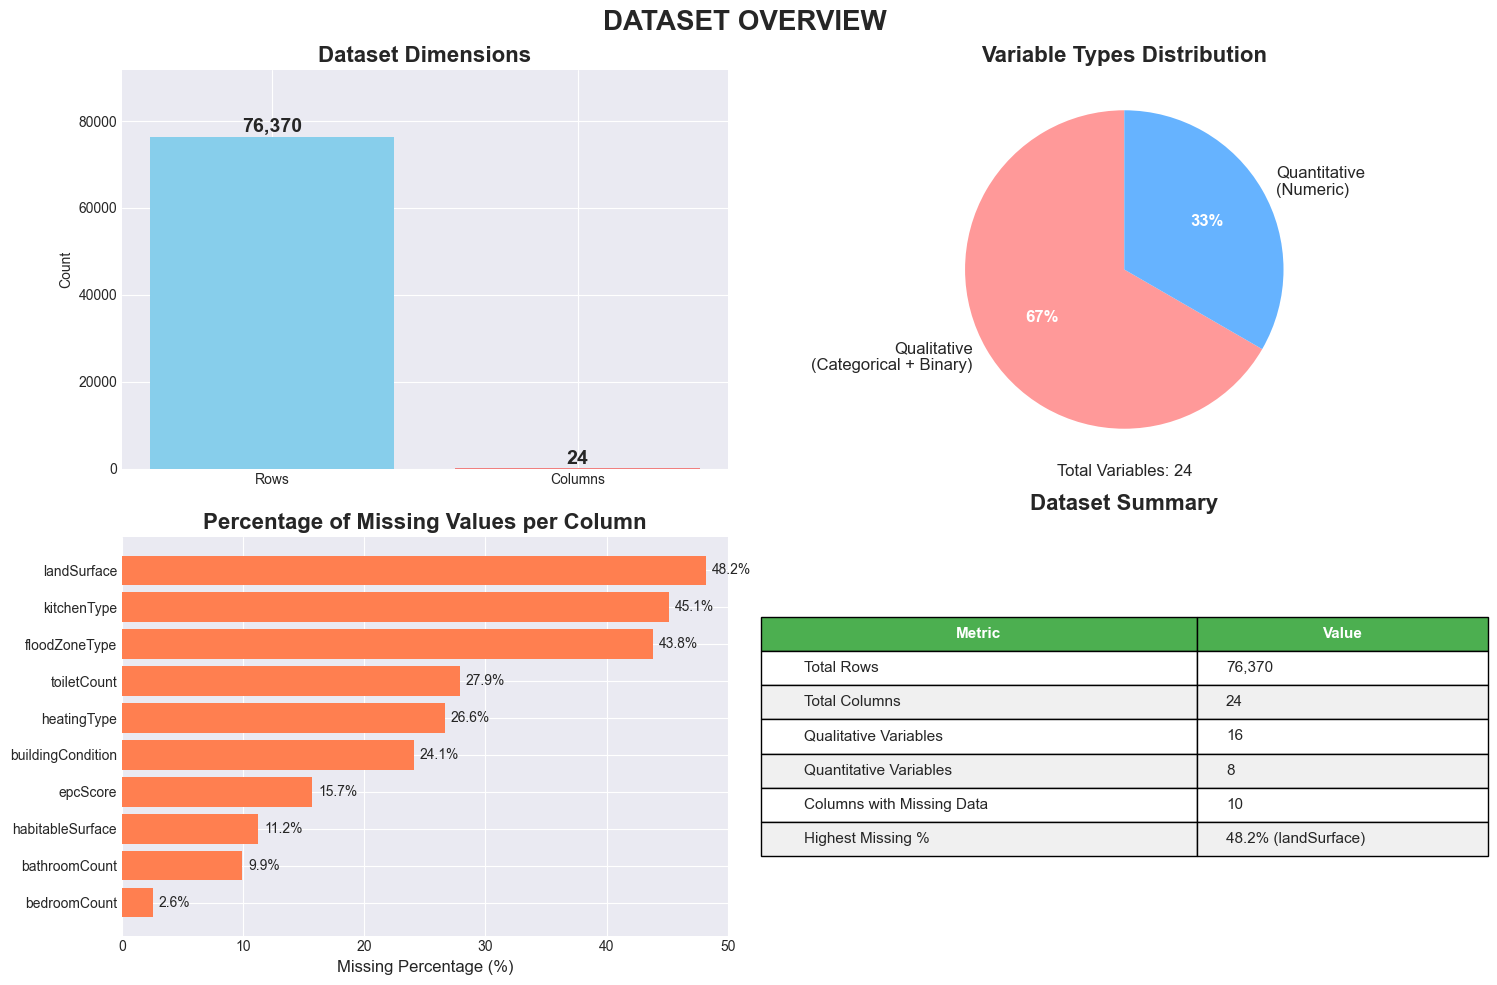

In [41]:
# ================================================= Visualization 1: Dataset Overview with 2 subplots ==================================================
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Dataset dimensions visualization
dims_data = ['Rows', 'Columns']
dims_values = [len(df), len(df.columns)]
bars1 = ax1.bar(dims_data, dims_values, color=['skyblue', 'lightcoral'])
ax1.set_title('Dataset Dimensions', fontsize=16, fontweight='bold')
ax1.set_ylabel('Count')
for i, (bar, val) in enumerate(zip(bars1, dims_values)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
             f'{val:,}', ha='center', va='bottom', fontsize=14, fontweight='bold')
ax1.set_ylim(0, max(dims_values) * 1.2)

# 2. Variable types visualization
var_types = ['Qualitative\n(Categorical + Binary)', 'Quantitative\n(Numeric)']
var_counts = [len(categorical_vars) + len(binary_vars), len(numeric_vars)]
colors = ['#ff9999', '#66b3ff']
wedges, texts, autotexts = ax2.pie(var_counts, labels=var_types, colors=colors, 
                                    autopct='%1.0f%%', startangle=90, 
                                    textprops={'fontsize': 12})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax2.set_title('Variable Types Distribution', fontsize=16, fontweight='bold')
# Add counts to labels
ax2.text(0, -1.3, f'Total Variables: {sum(var_counts)}', ha='center', fontsize=12)

# 3. Missing values percentage bar chart
missing_sorted = missing_df[missing_df['Percentage'] > 0].sort_values('Percentage', ascending=True)
bars3 = ax3.barh(missing_sorted['Column'], missing_sorted['Percentage'], color='coral')
ax3.set_xlabel('Missing Percentage (%)', fontsize=12)
ax3.set_title('Percentage of Missing Values per Column', fontsize=16, fontweight='bold')
ax3.set_xlim(0, 50)
for i, (bar, pct) in enumerate(zip(bars3, missing_sorted['Percentage'])):
    ax3.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{pct:.1f}%', ha='left', va='center', fontsize=10)

# 4. Summary statistics table
summary_data = [
    ['Total Rows', f'{len(df):,}'],
    ['Total Columns', f'{len(df.columns)}'],
    ['Qualitative Variables', f'{len(categorical_vars) + len(binary_vars)}'],
    ['Quantitative Variables', f'{len(numeric_vars)}'],
    ['Columns with Missing Data', f'{len(missing_sorted)}'],
    ['Highest Missing %', f'{missing_sorted["Percentage"].max():.1f}% ({missing_sorted.iloc[-1]["Column"]})']
]

ax4.axis('tight')
ax4.axis('off')
table = ax4.table(cellText=summary_data, 
                  colLabels=['Metric', 'Value'],
                  cellLoc='left',
                  loc='center',
                  colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)
ax4.set_title('Dataset Summary', fontsize=16, fontweight='bold', pad=20)

# Style the table
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_facecolor('#4CAF50')
        cell.set_text_props(weight='bold', color='white')
    else:
        cell.set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')

plt.suptitle('DATASET OVERVIEW', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

Analysis of outlier

In [ ]:
# ==================================== Function to plot numeric variables with outlier information ========================================

def plot_numeric_with_outliers(df, col, ax):
    """Plot numeric variable with outlier information"""
    data = df[col].dropna()  #drop NaN values, only analysis meaningful values
    
    # If no data, show message and return
    if len(data) == 0: # check if the column is a fully empty column
        ax.text(0.5, 0.5, f'No data available for {col}', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{col} - No Data') #change title to No data
        return
    
    # Calculate outliers using Interquartile Range method.Calculate Q1, Q3 and IQR
    Q1 = data.quantile(0.25) # 25% data < Q1
    Q3 = data.quantile(0.75) # 75% data < Q3
    IQR = Q3 - Q1 # range of 50% data in the middle 
    lower_bound = Q1 - 1.5 * IQR # lower limit calculating way, if lower than this, then it is outlier below
    upper_bound = Q3 + 1.5 * IQR # upper limit calculating way, if upper than this, then is is outlier above
    
    # Count outliers below and above the limits
    outliers_below = (data < lower_bound).sum() #True = 1, False = 0
    outliers_above = (data > upper_bound).sum()
    
    # Draw horizontal boxplot with styling
    ax.boxplot(data, vert=False, patch_artist=True, # horizontal, with color
               boxprops=dict(facecolor='lightblue', alpha=0.7), #box color
               medianprops=dict(color='red', linewidth=2)) # median color and line
    
     # Annotate counts of outliers on the plot
    ax.text(0.02, 0.95, f'Below lower limit: {outliers_below}', 
            transform=ax.transAxes, va='top', fontsize=10)
    ax.text(0.02, 0.85, f'Above upper limit: {outliers_above}', 
            transform=ax.transAxes, va='top', fontsize=10)
    
    # Set x-axis label and title
    ax.set_xlabel(col)
    ax.set_title(f'{col} Distribution with Outliers', fontsize=12)


Visualization 2: Numeric Variables with Outliers

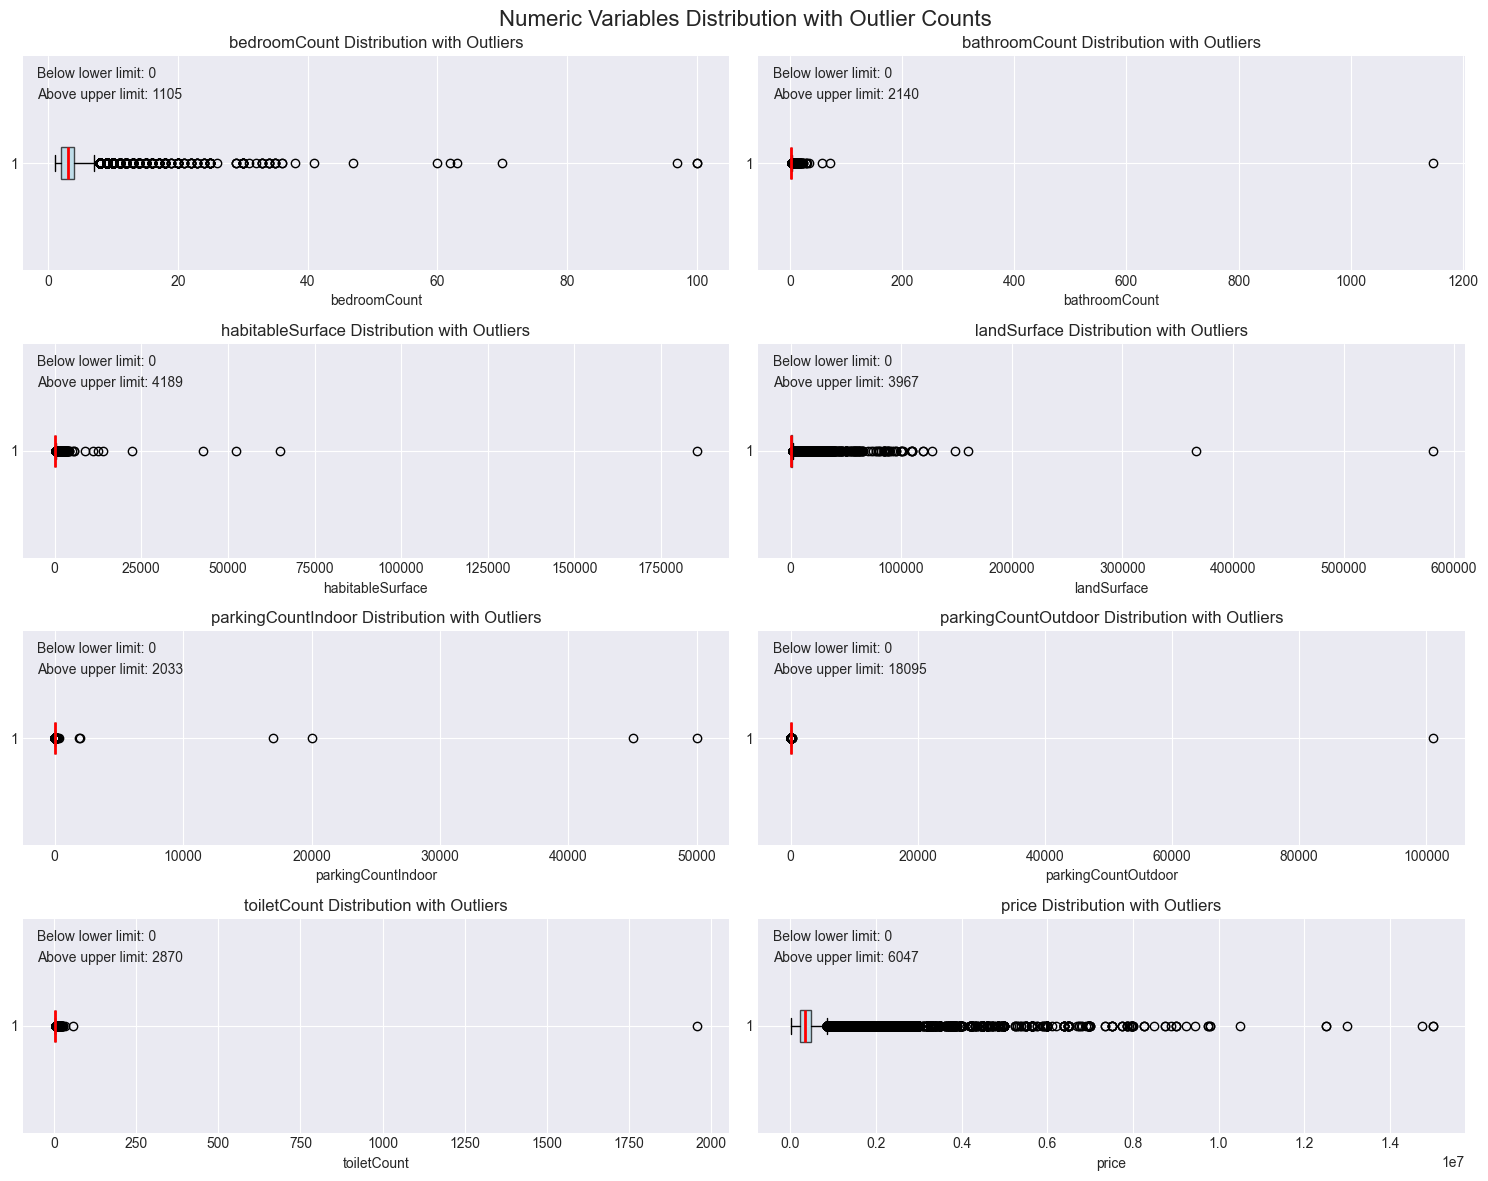

In [37]:
# ============================================ Visualization 2: Numeric Variables with Outliers =======================================================

# Create subplots (4 rows x 2 cols) and flatten axes array
fig, axes = plt.subplots(4, 2, figsize=(15, 12)) # 8 subplots for 8 numeric columns
axes = axes.ravel() # make sure subplot is one dimensional array

# Loop through numeric variables and plot each
for i, col in enumerate(numeric_vars):
    if i < len(axes):
        plot_numeric_with_outliers(df, col, axes[i]) # draw {i} column in {i} plot 

# Overall title and layout adjustment
plt.suptitle('Numeric Variables Distribution with Outlier Counts', fontsize=16) #suptitle for whole plot
plt.tight_layout()
plt.show()

In [ ]:
# Remove outliers from 'price' and 'parkingCountOutdoor' columns using IQR method
print("\nRemoving outliers in 'price' and 'parkingCountOutdoor' columns using IQR method...")

def get_iqr_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

# 
price_lower, price_upper = get_iqr_bounds(df['price'].dropna())
parking_lower, parking_upper = get_iqr_bounds(df['parkingCountOutdoor'].dropna())

#
before_rows = len(df)

# 
df = df[
    (df['price'] >= price_lower) & (df['price'] <= price_upper) &
    (df['parkingCountOutdoor'] >= parking_lower) & (df['parkingCountOutdoor'] <= parking_upper)
]

# 
after_rows = len(df)
print(f"Removed {before_rows - after_rows} rows with outliers in 'price' or 'parkingCountOutdoor'.")



Removing outliers in 'price' and 'parkingCountOutdoor' columns using IQR method...
Removed 22136 rows with outliers in 'price' or 'parkingCountOutdoor'.


Comprehensive Correlation Analysis(numeric)  - using corr

In [38]:
# ============================================= Comprehensive Correlation Analysis(numeric)  - using corr ===========================================================

# Print separator and title for correlation analysis
print("\n" + "="*80)
print("COMPREHENSIVE CORRELATION ANALYSIS WITH PRICE")
print("="*80)

# 1. Get only numeric columns for correlation
# Select numeric dtype columns from the DataFrame
numeric_df = df[numeric_vars].select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr() # using corr matrix to get correlations of all numericals

# Get correlations with price if exists
if 'price' in corr_matrix.columns:
    # Extract correlations with 'price', drop self-correlation, sort descending
    price_correlations_numeric = corr_matrix['price'].drop('price').sort_values(ascending=False)
    print("\n1. NUMERIC VARIABLES - Correlation with Price:")
    # Print each variable and its correlation coefficient
    for var, corr in price_correlations_numeric.items():
        print(f"{var}: {corr:.4f}") # loop correlated variables and keep 4 digits after the decimal point

# Calculate correlations of numeric
print("\n" + "="*80)
print("CORRELATION ANALYSIS(numeric) WITH PRICE")
print("="*80)

# Get only numeric columns for correlation
numeric_df = df[numeric_vars].select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Get correlations with price
if 'price' in corr_matrix.columns:
    price_correlations = corr_matrix['price'].drop('price').sort_values(ascending=False)
    print("\nCorrelations with Price (sorted by absolute value):")
    for var, corr in price_correlations.items():
        print(f"{var}: {corr:.4f}")
    
    # Identify greatest and least influences
    strong_influence = price_correlations[abs(price_correlations) > 0.3]
    weak_influence = price_correlations[abs(price_correlations) < 0.1]
    
    print(f"\nVariables with GREATEST influence on price (|correlation| > 0.3):")
    for var, corr in strong_influence.items():
        print(f"  - {var}: {corr:.4f}")
    
    print(f"\nVariables with LEAST influence on price (|correlation| < 0.1):")
    for var, corr in weak_influence.items():
        print(f"  - {var}: {corr:.4f}")


COMPREHENSIVE CORRELATION ANALYSIS WITH PRICE

1. NUMERIC VARIABLES - Correlation with Price:
bedroomCount: 0.3686
landSurface: 0.2261
bathroomCount: 0.1119
habitableSurface: 0.0979
toiletCount: 0.0958
parkingCountOutdoor: 0.0067
parkingCountIndoor: -0.0004

CORRELATION ANALYSIS(numeric) WITH PRICE

Correlations with Price (sorted by absolute value):
bedroomCount: 0.3686
landSurface: 0.2261
bathroomCount: 0.1119
habitableSurface: 0.0979
toiletCount: 0.0958
parkingCountOutdoor: 0.0067
parkingCountIndoor: -0.0004

Variables with GREATEST influence on price (|correlation| > 0.3):
  - bedroomCount: 0.3686

Variables with LEAST influence on price (|correlation| < 0.1):
  - habitableSurface: 0.0979
  - toiletCount: 0.0958
  - parkingCountOutdoor: 0.0067
  - parkingCountIndoor: -0.0004


Correlation (numeric) with price

Text(0.5, 1.0, 'Correlation Matrix - Top Variables')

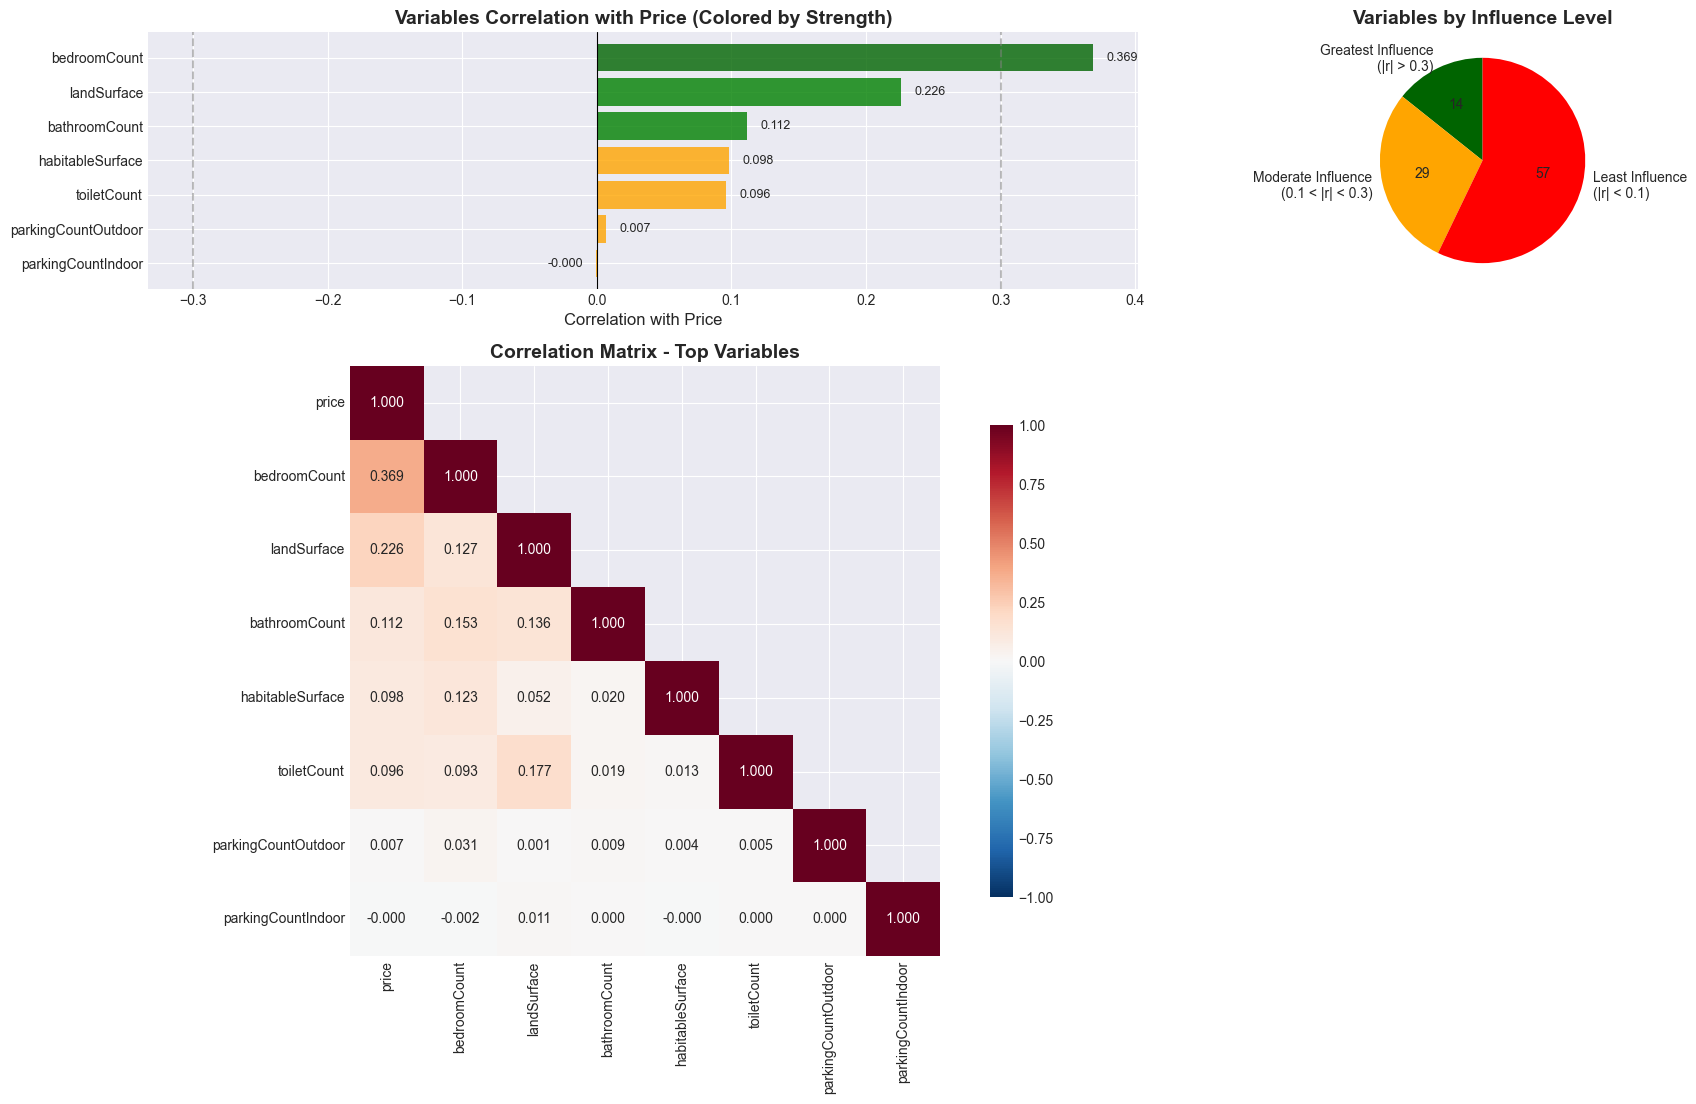

In [ ]:
# ================================================= Visualization 3: Correlation (numeric) with price ==========================================================
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Correlation with Price - Bar Chart
ax1 = fig.add_subplot(gs[0, :2])
price_corr_sorted = price_correlations.reindex(price_correlations.abs().sort_values(ascending=True).index)
colors = ['darkgreen' if x > 0.3 else 'green' if x > 0.1 else 'orange' if x > -0.1 else 'red' 
          for x in price_corr_sorted.values]
bars = ax1.barh(range(len(price_corr_sorted)), price_corr_sorted.values, color=colors, alpha=0.8)

ax1.set_yticks(range(len(price_corr_sorted)))
ax1.set_yticklabels(price_corr_sorted.index)
ax1.set_xlabel('Correlation with Price', fontsize=12)
ax1.set_title('Variables Correlation with Price (Colored by Strength)', fontsize=14, fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax1.axvline(x=0.3, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(x=-0.3, color='gray', linestyle='--', alpha=0.5)

# Add value labels
for i, (value, bar) in enumerate(zip(price_corr_sorted.values, bars)):
    ax1.text(value + 0.01 if value > 0 else value - 0.01, bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', ha='left' if value > 0 else 'right', va='center', fontsize=9)

# 2. Influence Categories
ax2 = fig.add_subplot(gs[0, 2])
influence_data = {
    'Greatest Influence\n(|r| > 0.3)': len(price_correlations[abs(price_correlations) > 0.3]),
    'Moderate Influence\n(0.1 < |r| < 0.3)': len(price_correlations[(abs(price_correlations) > 0.1) & (abs(price_correlations) <= 0.3)]),
    'Least Influence\n(|r| < 0.1)': len(price_correlations[abs(price_correlations) <= 0.1])
}
colors_pie = ['darkgreen', 'orange', 'red']
wedges, texts, autotexts = ax2.pie(influence_data.values(), labels=influence_data.keys(), 
                                    colors=colors_pie, autopct='%1.0f', startangle=90)
ax2.set_title('Variables by Influence Level', fontsize=14, fontweight='bold')

# 3. Correlation(all numeric) Heatmap
ax3 = fig.add_subplot(gs[1:, :2])
# Select top correlated variables for cleaner visualization
top_vars_idx = price_correlations.abs().nlargest(min(8, len(price_correlations))).index
top_vars = ['price'] + list(top_vars_idx)
# Only include variables that exist in the correlation matrix
top_vars = [v for v in top_vars if v in corr_matrix.columns]
corr_subset = corr_matrix.loc[top_vars, top_vars]

mask = np.triu(np.ones_like(corr_subset, dtype=bool), k=1)
sns.heatmap(corr_subset, annot=True, fmt='.3f', cmap='RdBu_r', 
            center=0, square=True, mask=mask, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax3, annot_kws={'size': 10})
ax3.set_title('Correlation Matrix - Top Variables', fontsize=14, fontweight='bold')

Comprehensive Correlation Analysis(category) - using ANOVA F-statistic and Eta-squared

In [31]:
# ===================================== Comprehensive Correlation Analysis(category) - using ANOVA F-statistic and Eta-squared ============================================

print("\n2. CATEGORICAL VARIABLES - Association with Price (ANOVA):")
categorical_results = []

# Loop through each categorical and binary variable
for var in categorical_vars + binary_vars:
    if var in df.columns:
        # Remove missing values for ANOVA test
        temp_df = df[[var, 'price']].dropna()
        
       # Only proceed if there is at least one row of data AND at least two distinct categories to compare
        if len(temp_df) > 0 and len(temp_df[var].unique()) > 1:
        # temp_df.groupby(var) splits the DataFrame into one subgroup per unique category in `var`
        # The list comprehension below collects each subgroup’s 'price' values into a NumPy array
        # Resulting `groups` is a list of 1D arrays, one array per category
            groups = [group['price'].values for _, group in temp_df.groupby(var)]
    
        # Perform a one-way ANOVA (analysis of variance) test across these groups
        # - The asterisk (*) unpacks the list so that each array becomes a separate argument
        # - stats.f_oneway returns:
        #     f_stat   : the F-statistic (ratio of between-group to within-group variability)
        #     p_value  : the probability of observing such an F under the null hypothesis
        # A small p_value (e.g., < 0.05) suggests the group means differ significantly
            f_stat, p_value = stats.f_oneway(*groups)
            
            # Calculate Eta-squared as effect size
            grand_mean = temp_df['price'].mean()  # overall average price
            ss_total = np.sum((temp_df['price'] - grand_mean) ** 2)  # total sum of squares
            ss_between = sum(
                len(group) * (group.mean() - grand_mean) ** 2
                for group in groups
            )  # between-group sum of squares
            eta_squared = ss_between / ss_total if ss_total > 0 else 0
            
            # Record results with interpretation
            categorical_results.append({
                'Variable': var,
                'F-statistic': f_stat,
                'p-value': p_value,
                'Eta-squared': eta_squared,
                'Effect': (
                    'Strong' if eta_squared > 0.14 else
                    'Medium' if eta_squared > 0.06 else
                    'Weak'
                )
            })

# Convert to DataFrame and sort by effect size
categorical_df = pd.DataFrame(categorical_results).sort_values('Eta-squared', ascending=False)
print("\nEffect size interpretation: Weak < 0.06, Medium 0.06-0.14, Strong > 0.14")
# Display the full table of categorical variable effects
print(categorical_df.to_string())



2. CATEGORICAL VARIABLES - Association with Price (ANOVA):

Effect size interpretation: Weak < 0.06, Medium 0.06-0.14, Strong > 0.14
             Variable  F-statistic        p-value  Eta-squared  Effect
4            postCode    22.941858   0.000000e+00     0.250572  Strong
1             subtype   496.823691   0.000000e+00     0.130188  Medium
14    hasSwimmingPool  5729.513754   0.000000e+00     0.069789  Medium
8         kitchenType   465.221241   0.000000e+00     0.046474    Weak
3            province   335.256178   0.000000e+00     0.042059    Weak
5   buildingCondition   468.332949   0.000000e+00     0.035492    Weak
2              region   664.133335   0.000000e+00     0.025427    Weak
9            epcScore   164.411061  5.131020e-310     0.019010    Weak
0                type   848.447975  1.649311e-185     0.010988    Weak
7         heatingType    56.039134   1.608710e-91     0.005837    Weak
15         hasTerrace   439.208737   3.027666e-97     0.005718    Weak
6       floodZ

Visualization 4: categorical variables' relationship with price 


Creating boxplots for 16 categorical/binary variables...


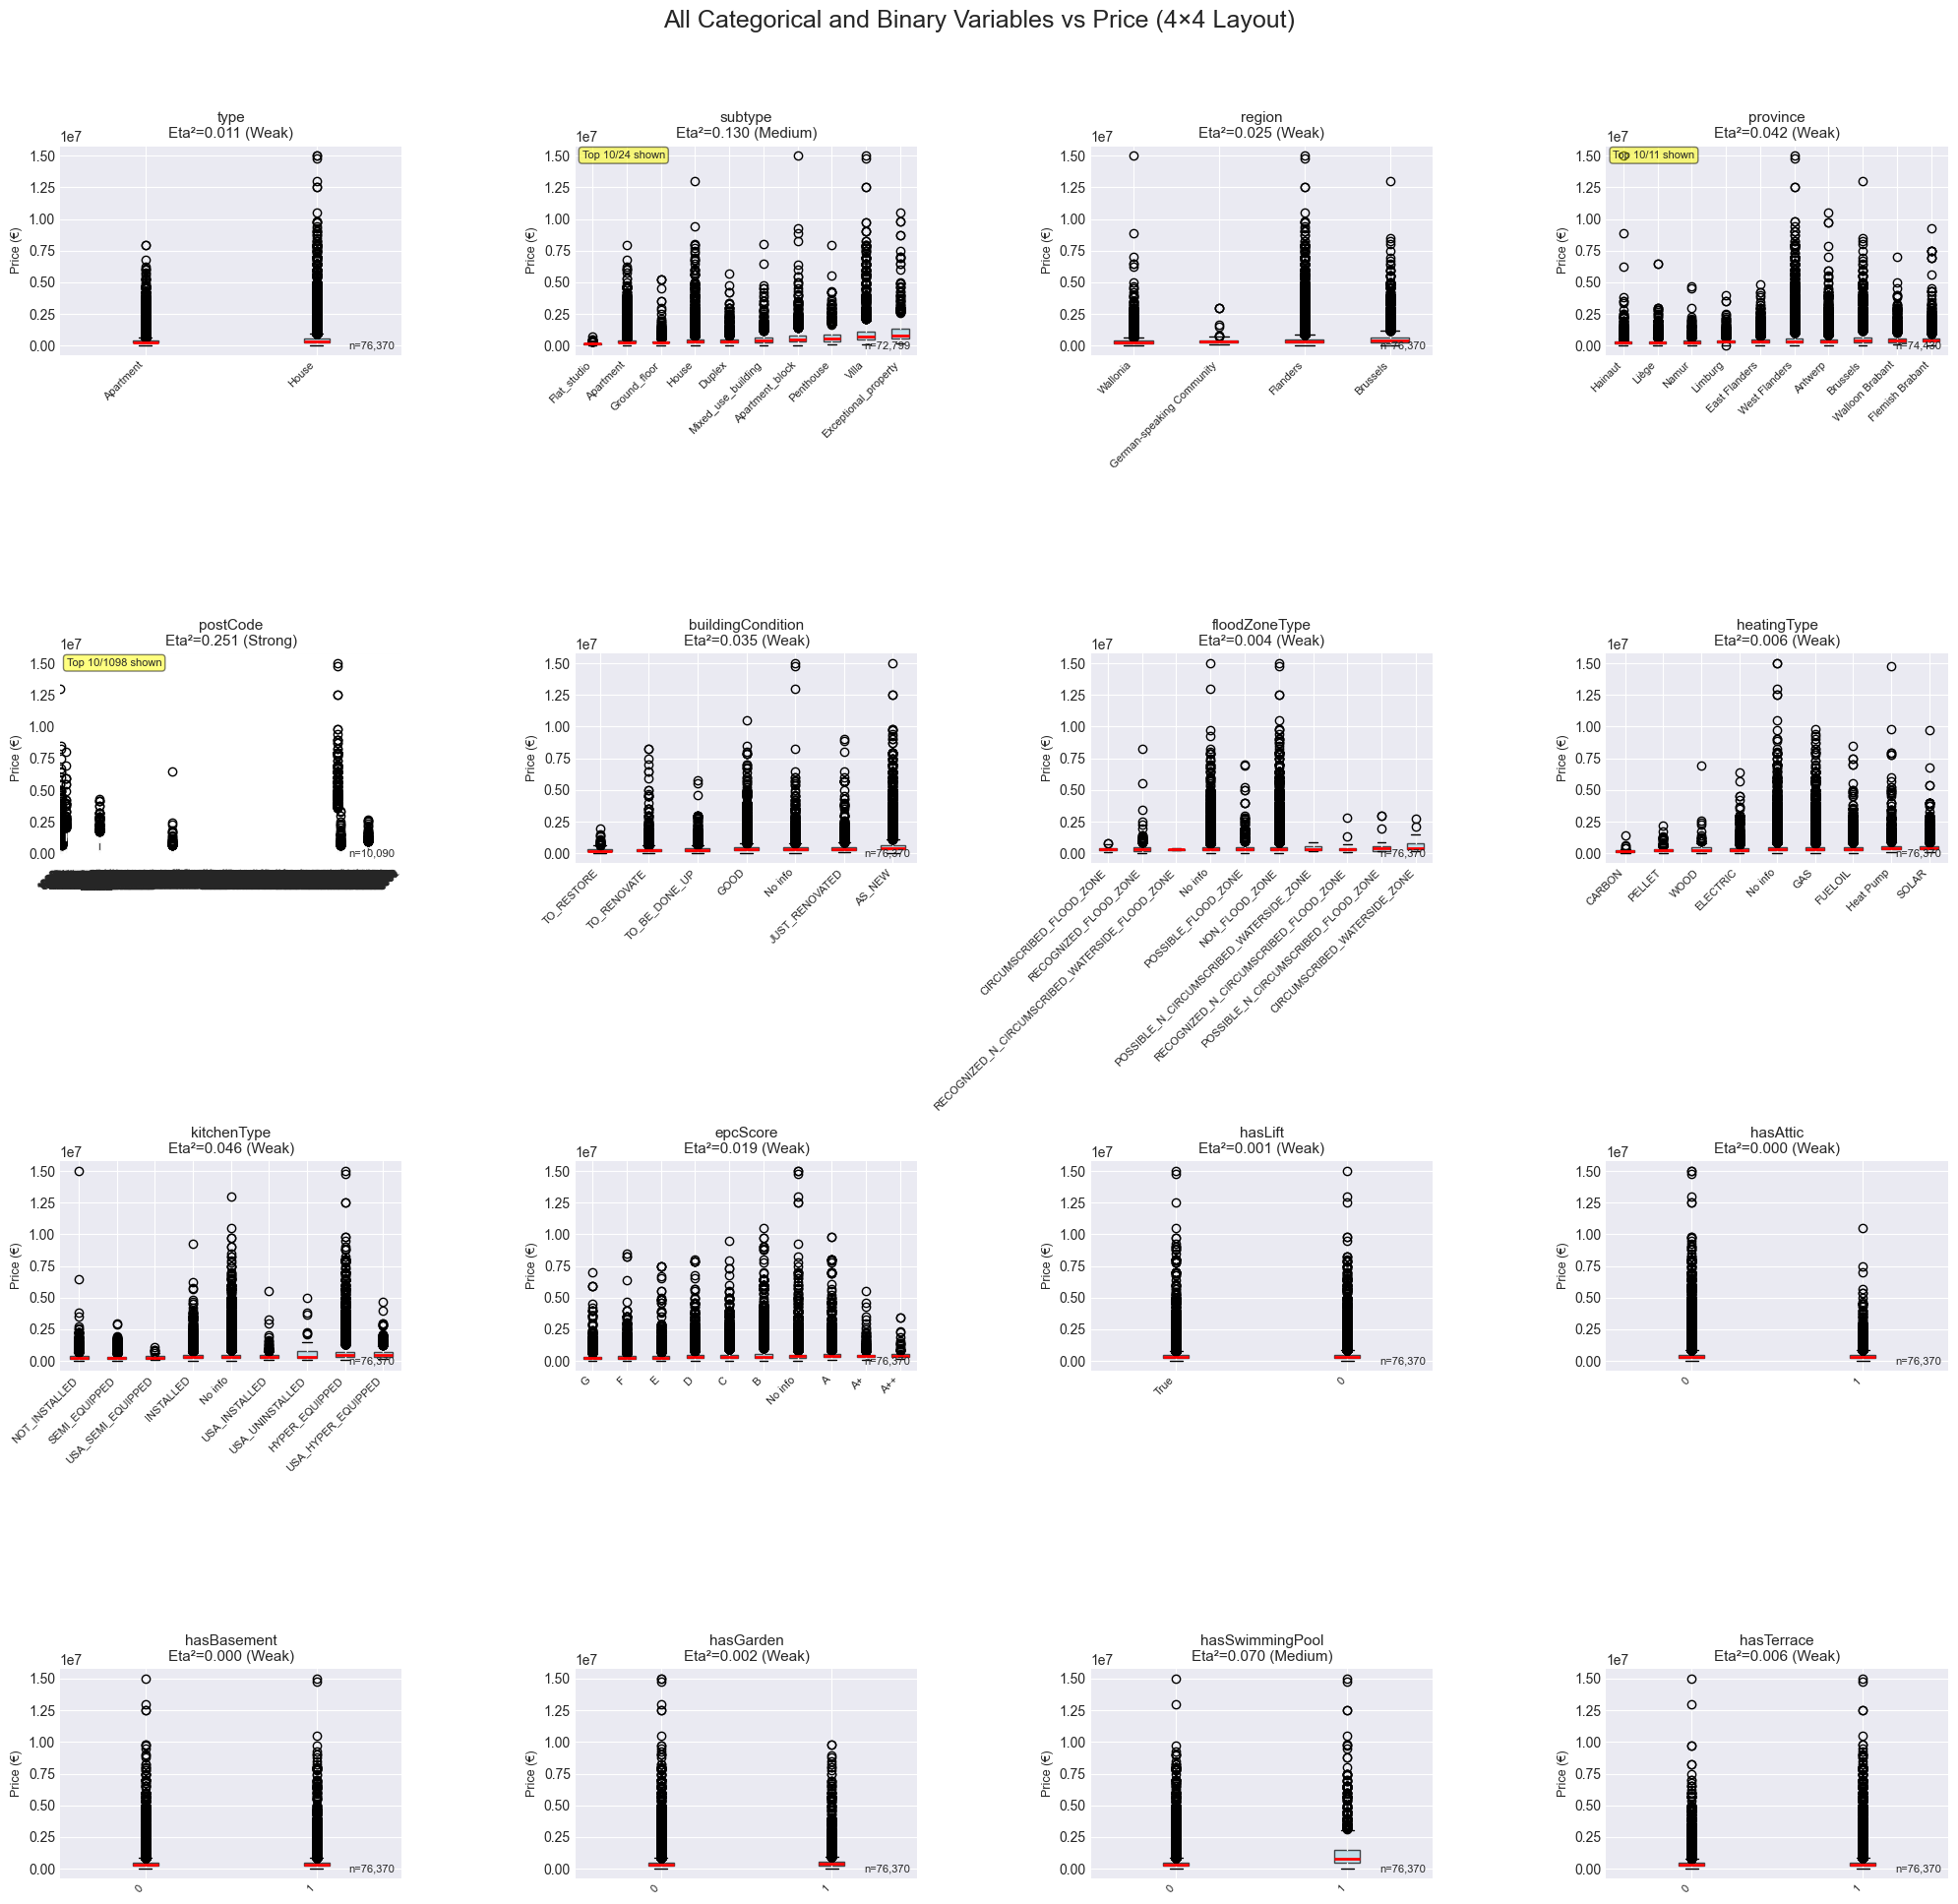


Total categorical variables analyzed: 11
Categorical variables: type, subtype, region, province, postCode, buildingCondition, floodZoneType, heatingType, kitchenType, epcScore, hasLift

Total binary variables analyzed: 5
Binary variables: hasAttic, hasBasement, hasGarden, hasSwimmingPool, hasTerrace

Total variables in visualization: 16


In [32]:
# ===============================================  Visualization 4: categorical variables' relationship with price ==============================================

# Display all categorical and binary variables in one grid of boxplots
# Combine lists of categorical and binary variables
all_categorical_vars = categorical_vars + binary_vars  # e.g., total 16 variables to plot
n_vars = len(all_categorical_vars)  # number of variables to visualize

# Create a 4x4 grid of subplots with a large figure size
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
# Flatten the 2D array of Axes into a 1D list for easy indexing
axes = axes.ravel()

# Inform the user how many plots will be created
print(f"\nCreating boxplots for {n_vars} categorical/binary variables...")

# Loop over each variable and corresponding subplot
for i, var in enumerate(all_categorical_vars):
    # Only proceed if we have an available subplot slot and the column exists in df
    if i < len(axes) and var in df.columns:
        ax = axes[i]
        
        # Subset the DataFrame to the current variable and price, dropping missing values
        temp_df = df[[var, 'price']].dropna()
        
        if len(temp_df) > 0:
            # If there are more than 10 unique categories, keep only the top 10 by frequency
            if len(temp_df[var].unique()) > 10:
                top_categories = temp_df[var].value_counts().head(10).index
                temp_df = temp_df[temp_df[var].isin(top_categories)]
                # Annotate the plot to show that only top 10 of all categories are displayed
                ax.text(
                    0.02, 0.98,
                    f'Top 10/{len(df[var].unique())} shown',
                    transform=ax.transAxes,
                    va='top', fontsize=8,
                    bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5)
                )
            
            # Sort categories by their median price for more meaningful boxplot order
            medians = temp_df.groupby(var)['price'].median().sort_values()
            temp_df[var] = pd.Categorical(
                temp_df[var],
                categories=medians.index,
                ordered=True
            )
            
            # Draw a horizontal boxplot of price grouped by current variable
            temp_df.boxplot(
                column='price',
                by=var,
                ax=ax,
                patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),  # light blue fill
                medianprops=dict(color='red', linewidth=2)         # red median line
            )
            
            # Retrieve Eta-squared effect size and qualitative label if available
            eta_sq_row = categorical_df[categorical_df['Variable'] == var]
            if not eta_sq_row.empty:
                eta_sq = eta_sq_row['Eta-squared'].values[0]
                effect = eta_sq_row['Effect'].values[0]
                ax.set_title(f'{var}\nEta²={eta_sq:.3f} ({effect})', fontsize=11)
            else:
                ax.set_title(f'{var}', fontsize=11)
            
            # Remove automatic x-axis label, set y-axis label
            ax.set_xlabel('')
            ax.set_ylabel('Price (€)', fontsize=9)
            
            # Hide pandas-generated suptitle for this subplot
            ax.get_figure().suptitle('')
            
            # Rotate x-axis labels to avoid overlap
            plt.setp(
                ax.xaxis.get_majorticklabels(),
                rotation=45, ha='right', fontsize=8
            )
            
            # Add a small text annotation showing the number of samples plotted
            n_samples = len(temp_df)
            ax.text(
                0.98, 0.02,
                f'n={n_samples:,}',
                transform=ax.transAxes,
                ha='right', va='bottom', fontsize=8
            )
        else:
            # If no data is available for this variable, show a placeholder message
            ax.text(
                0.5, 0.5,
                f'No data for {var}',
                ha='center', va='center',
                transform=ax.transAxes
            )
            ax.set_title(f'{var}', fontsize=11)

# In case we have more subplot axes than variables, hide any unused axes
for i in range(len(all_categorical_vars), len(axes)):
    axes[i].axis('off')

# Add a main title for the entire figure and adjust layout
plt.suptitle(
    'All Categorical and Binary Variables vs Price (4×4 Layout)',
    fontsize=18, y=0.995
)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# Print a summary of which variables were analyzed
print(f"\nTotal categorical variables analyzed: {len(categorical_vars)}")
print("Categorical variables:", ', '.join(categorical_vars))
print(f"\nTotal binary variables analyzed: {len(binary_vars)}")
print("Binary variables:", ', '.join(binary_vars))
print(f"\nTotal variables in visualization: {len(all_categorical_vars)}")

All variables ranked by influence on price

In [ ]:
# ====================================================== All variables ranked by influence on price ==================================================================

print("\n" + "="*80)
print("ALL VARIABLES RANKED BY INFLUENCE ON PRICE")
print("="*80)

all_variables = []

# add numeric variables
for var, corr in price_correlations.items():
    all_variables.append({
        'Variable': var,
        'Type': 'Numeric',
        'Effect Size': abs(corr),
        'Metric': f'r = {corr:.3f}',
        'Interpretation': 'Strong' if abs(corr) > 0.3 else 'Medium' if abs(corr) > 0.1 else 'Weak'
    })

# add category variables
for _, row in categorical_df.iterrows():
    all_variables.append({
        'Variable': row['Variable'],
        'Type': 'Categorical',
        'Effect Size': row['Eta-squared'],
        'Metric': f'η² = {row["Eta-squared"]:.3f}',
        'Interpretation': row['Effect']
    })

all_vars_df = pd.DataFrame(all_variables).sort_values('Effect Size', ascending=False)
print("\nTOP 10 MOST INFLUENTIAL VARIABLES:")
print(all_vars_df.head(10).to_string(index=False))